# EDA

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
# raw_ppg_signal_df = pd.read_csv("../../data/subject3/raw/1.csv")
# processed_ppg_signal_df = pd.read_csv("../../data/subject3/processed/1.csv")
raw_ppg_signal_df = pd.read_csv("../../data/subject200/subject200.csv")

In [28]:
raw_ppg_signal_df.head(5)

,Unnamed: 0,In,Ref,Pressure_In
0,0,2.931131,159.610471,0.972630
1,1,14.149493,393.549343,0.975243
2,2,31.013818,698.653602,0.977397
3,3,52.641386,1094.011979,0.971844
4,4,78.767343,1539.126115,0.972329


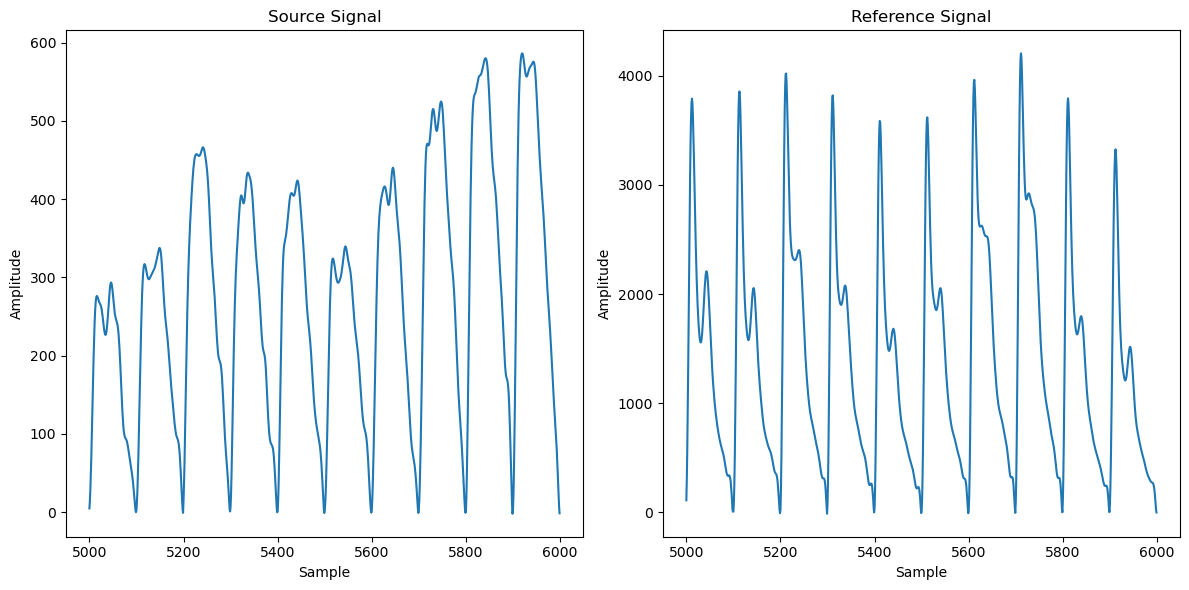

In [29]:
def plot_wavform(src_ppg_signal, ref_ppg_signal):
    assert len(src_ppg_signal) == len(ref_ppg_signal)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(ppg_source[5000:6000])
    ax1.set_title("Source Signal")
    ax1.set_xlabel("Sample")
    ax1.set_ylabel("Amplitude")

    ax2.plot(ppg_reference[5000:6000])
    ax2.set_title("Reference Signal")
    ax2.set_xlabel("Sample")
    ax2.set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

ppg_source = raw_ppg_signal_df["In"]
ppg_reference = raw_ppg_signal_df["Ref"]
plot_wavform(ppg_source, ppg_reference)

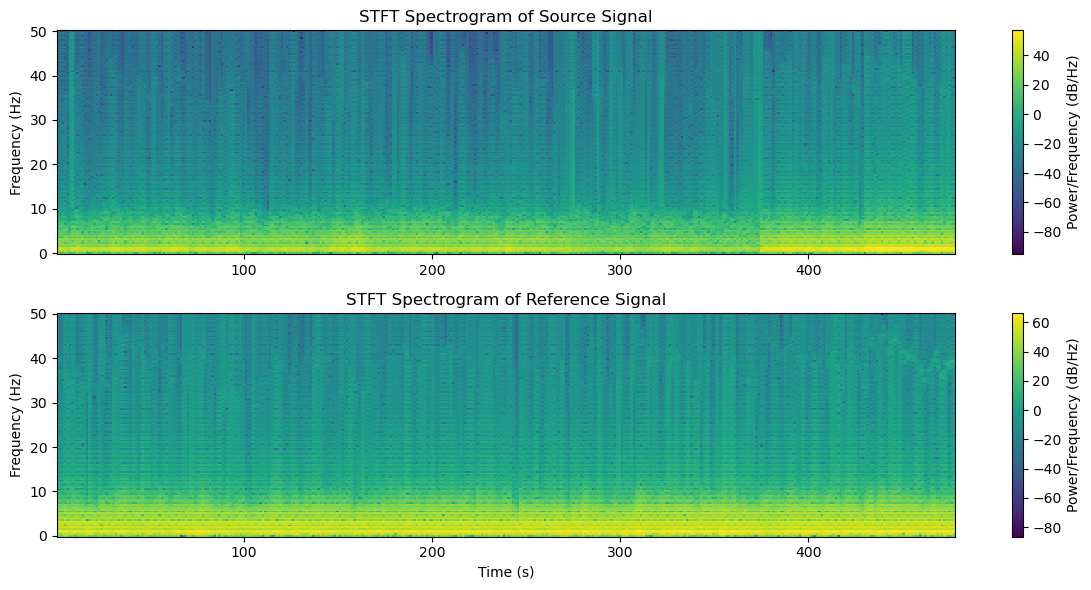

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

ppg_source = raw_ppg_signal_df["In"]
ppg_reference = raw_ppg_signal_df["Ref"]

fs = 100  
nperseg = 256  
noverlap = 128  

f_source, t_source, Sxx_source = spectrogram(ppg_source, fs=fs, nperseg=nperseg, noverlap=noverlap)
f_reference, t_reference, Sxx_reference = spectrogram(ppg_reference, fs=fs, nperseg=nperseg, noverlap=noverlap)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(t_source, f_source, 10 * np.log10(Sxx_source), shading='auto')
plt.title("STFT Spectrogram of Source Signal")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power/Frequency (dB/Hz)")

plt.subplot(2, 1, 2)
plt.pcolormesh(t_reference, f_reference, 10 * np.log10(Sxx_reference), shading='auto')
plt.title("STFT Spectrogram of Reference Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power/Frequency (dB/Hz)")

plt.tight_layout()
plt.show()

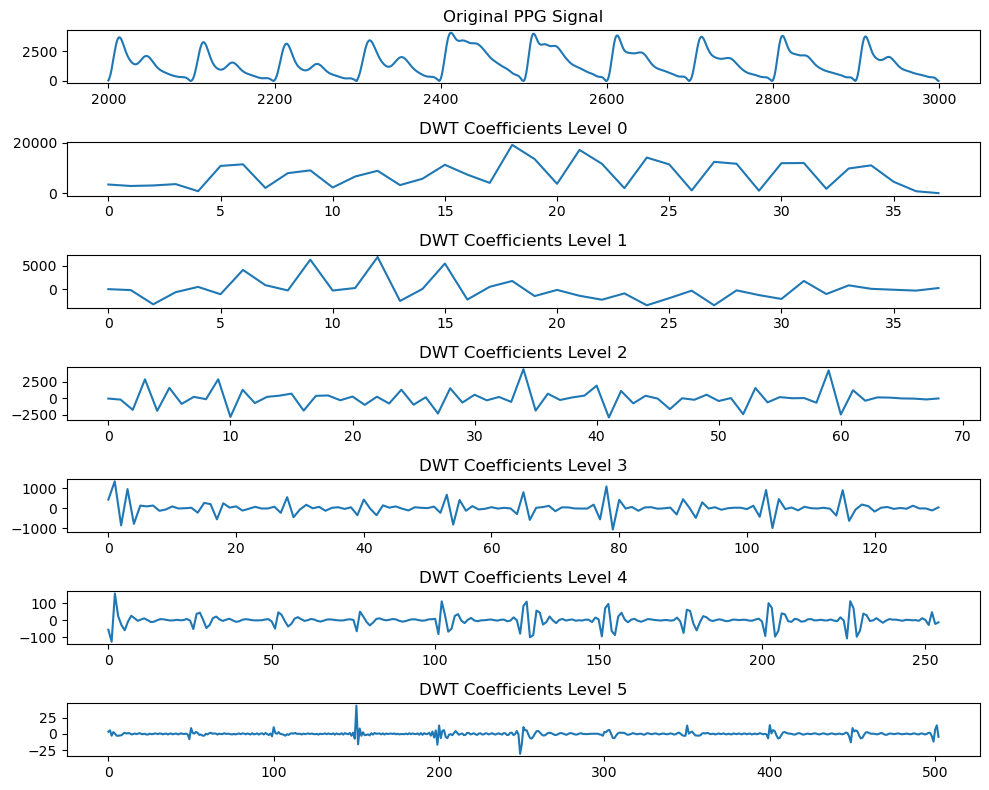

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pywt


wavelet = 'db4'  
level = 5      
coeffs = pywt.wavedec(ppg_reference[2000:3000], wavelet, level=level)

plt.figure(figsize=(10, 8))

plt.subplot(level+2, 1, 1)
plt.plot(ppg_reference[2000:3000])
plt.title('Original PPG Signal')

for i in range(level+1):
    plt.subplot(level+2, 1, i+2)
    plt.plot(coeffs[i])
    plt.title(f'DWT Coefficients Level {i}')

plt.tight_layout()
plt.show()


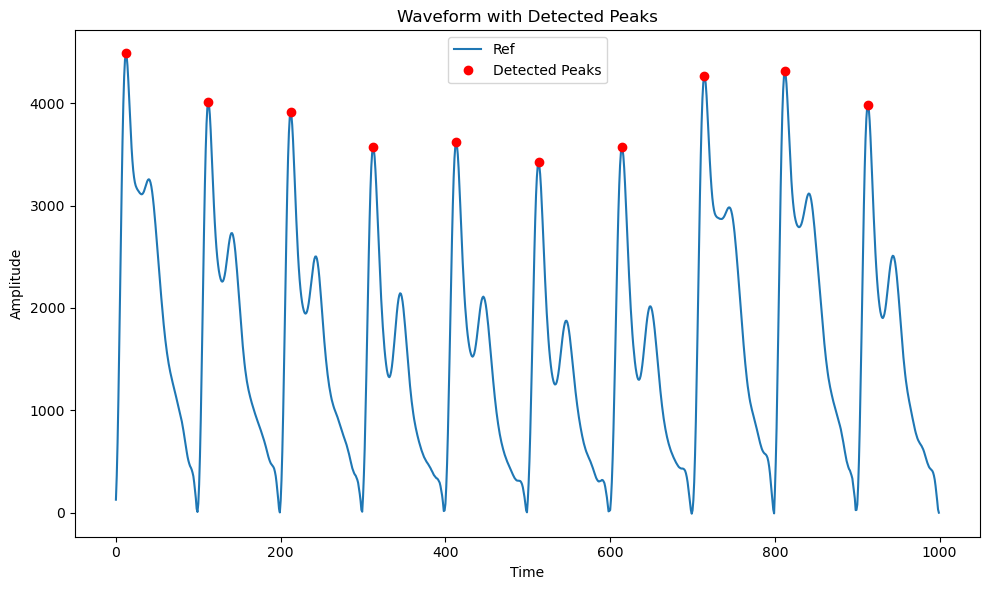

In [32]:
from scipy import interpolate, signal

time_column = np.array(list(range(1000)))
ppg_ref_lpf_column = raw_ppg_signal_df['Ref'].values[1000:2000]

peaks, _ = signal.find_peaks(ppg_ref_lpf_column, distance=40, prominence=100)
line = interpolate.CubicSpline(time_column[peaks], ppg_ref_lpf_column[peaks])

ppg_ref_ac_column = (ppg_ref_lpf_column - line(time_column)) 

ac_peaks, _ = signal.find_peaks(ppg_ref_ac_column, distance=40, prominence=100)

plt.figure(figsize=(10, 6))
plt.plot(time_column, ppg_ref_lpf_column, label='Ref')
plt.plot(time_column[peaks], ppg_ref_lpf_column[peaks], 'ro', label='Detected Peaks')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Waveform with Detected Peaks')
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
def calculate_statistical_features(signal):
    mean = np.mean(signal)
    median = np.median(signal)
    std_dev = np.std(signal)

    stats = {
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_dev
    }
    for feature, value in stats.items():
        print(f'{feature}: {value}')
    return stats

result_raw = calculate_statistical_features(raw_ppg_signal_df["In"])
print("*****************************************************************************")
result_processed = calculate_statistical_features(raw_ppg_signal_df["Ref"])

Mean: 336.7735706243871
Median: 232.0916382178487
Standard Deviation: 355.4028491459558
*****************************************************************************
Mean: 1909.743057111374
Median: 1680.1988355128137
Standard Deviation: 1354.4436817983164


In [34]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch, periodogram

fs = 100 
frequencies, power_spectrum = welch(ppg_reference, fs=fs)
spectral_ent = -np.sum(power_spectrum * np.log2(power_spectrum))

normalized_signal = (ppg_reference - np.mean(ppg_reference)) / np.std(ppg_reference)
hist, bin_edges = np.histogram(normalized_signal, bins='auto', density=True)
shannon_ent = -np.sum(hist * np.log2(hist))

f, Pxx = periodogram(ppg_reference, fs=fs)
approx_ent = -np.log(np.sum(Pxx * (f[1] - f[0])))

kurt = kurtosis(ppg_reference)

skewness = skew(ppg_reference)

signal_power = np.square(ppg_reference).mean()

print(f"Spectral Entropy: {spectral_ent:.3f}")
print(f"Shannon Entropy: {shannon_ent:.3f}")
print(f"Approximate Entropy: {approx_ent:.3f}")
print(f"Kurtosis: {kurt:.3f}")
print(f"Skewness: {skewness:.3f}")
print(f"Signal_power: {signal_power:.3f}")



Spectral Entropy: -81555050.598
Shannon Entropy: 20.293
Approximate Entropy: -14.422
Kurtosis: -0.656
Skewness: 0.550
Signal_power: 5481636.231


In [35]:

def calculate_rmssd(signal1, signal2):
    rr_intervals1 = np.diff(signal1)
    rr_intervals2 = np.diff(signal2)
    
    sq_diff = (rr_intervals2 - rr_intervals1) ** 2
    mean_sq_diff = np.mean(sq_diff)
    rmssd = np.sqrt(mean_sq_diff)
    
    return rmssd

calculate_rmssd(ppg_reference/max(ppg_reference), ppg_source/max(ppg_source))

0.019625494776213576

In [36]:
import numpy as np
import scipy.signal

def calculate_peak_to_peak_error(original_signal, reconstructed_signal, sampling_rate):
    original_peaks, _ = scipy.signal.find_peaks(original_signal, distance=40, prominence=100)
    reconstructed_peaks, _ = scipy.signal.find_peaks(reconstructed_signal, distance=40, prominence=100)
    
    paired_peaks = []
    for orig_peak in original_peaks:
        closest_recon_peak_idx = np.argmin(np.abs(reconstructed_peaks - orig_peak))
        closest_recon_peak = reconstructed_peaks[closest_recon_peak_idx]
        paired_peaks.append((orig_peak, closest_recon_peak))
        
        reconstructed_peaks = np.delete(reconstructed_peaks, closest_recon_peak_idx)
    
    peak_to_peak_errors = [abs(orig_peak - recon_peak) for orig_peak, recon_peak in paired_peaks]
    
    max_peak_to_peak_error = max(peak_to_peak_errors)
    
    heart_rate_error = (max_peak_to_peak_error / sampling_rate) * 60
    
    return max_peak_to_peak_error, heart_rate_error



max_peak_to_peak_error, heart_rate_error = calculate_peak_to_peak_error(original_signal=raw_ppg_signal_df['In'], reconstructed_signal=raw_ppg_signal_df['Ref'], sampling_rate=100)
print(f"Maximum Peak-to-Peak Error: {max_peak_to_peak_error}")
print(f"Heart Rate Error: {heart_rate_error} BPM")


Maximum Peak-to-Peak Error: 42
Heart Rate Error: 25.2 BPM


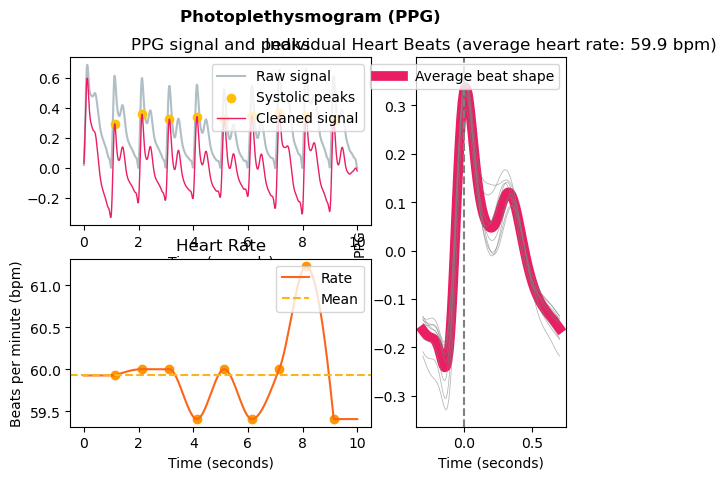

In [37]:
import numpy as np
import pandas as pd
import neurokit2 as nk

signals, info = nk.ppg_process(raw_ppg_signal_df['Ref'][1000:2000]/max(raw_ppg_signal_df['Ref']), sampling_rate=100)
nk.ppg_plot(signals, info)



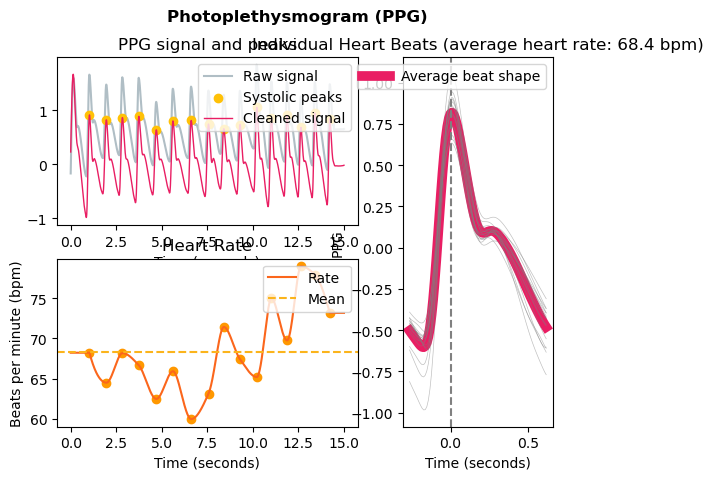

In [38]:
#simulate
ppg = nk.ppg_simulate(duration=15, sampling_rate=100, heart_rate=70)

signals, info = nk.ppg_process(ppg, sampling_rate=100)

nk.ppg_plot(signals, info)

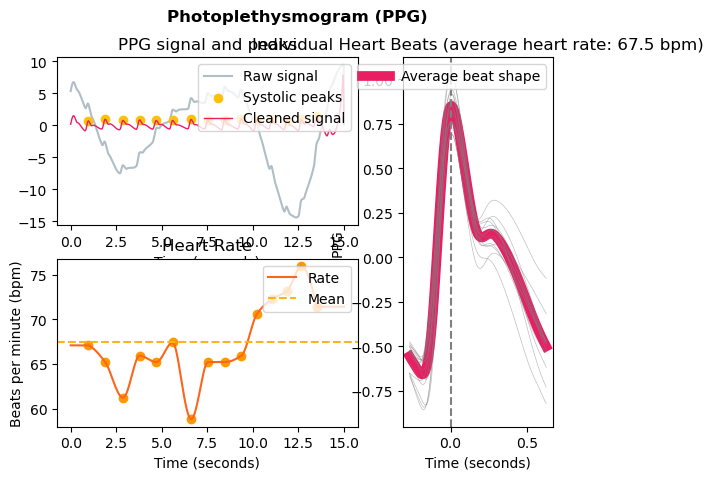

In [39]:
#simulate
ppg = nk.ppg_simulate(duration=15, sampling_rate=100, heart_rate=70, motion_amplitude=5)

signals, info = nk.ppg_process(ppg, sampling_rate=100)

nk.ppg_plot(signals, info)

0.8507554123998099


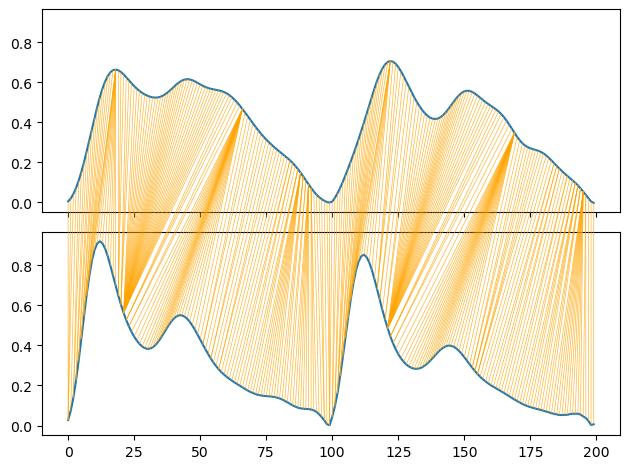

In [55]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np

s1 = ppg_source.values[600:800] / max(ppg_source.values[:100] )
s2 = ppg_reference.values[600:800] / max(ppg_reference.values[:100] )
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)
print(dtw.distance_fast(s1, s2, use_pruning=True))
